# Import libraries

In [4]:
from transformers import pipeline 
import numpy as np
import torch
import pandas as pd 
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
from utils import *
bert_ckpt = "phnghiapro/distilbert-base-uncased-distilled-clinc"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pipe = pipeline('text-classification', model=bert_ckpt, device=device) 
print("device : ",device)
print("device of pipeline : ", pipe.model.device)


device :  cuda:0
device of pipeline :  cuda:0


# plot the distribution of the weights

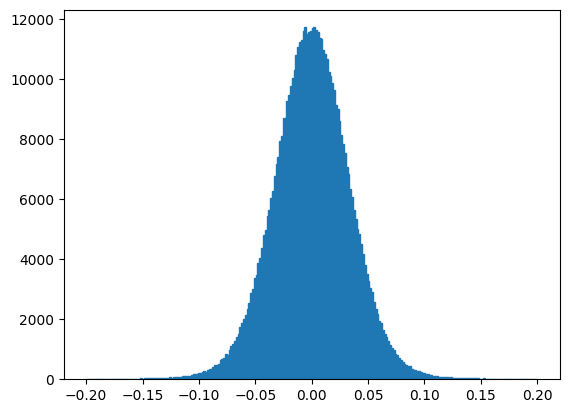

In [5]:
state_dict = pipe.model.to('cpu').state_dict()
weights = state_dict['distilbert.transformer.layer.0.attention.out_lin.weight']
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.2,0.2), edgecolor="C0")
plt.show()

In [6]:
# value distributed in small range [-0.1, 0.1]
zero_point = 0 
scale = (weights.max() - weights.min()) / 255 

In [7]:
(weights / scale + zero_point).clamp(-128,127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   0],
        [ -9,  -6,   6,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,   0],
        [  1,  -3, -12,  ...,  12,  -7, -13],
        [-12,   0, -10,  ...,   8,   2,   0]], dtype=torch.int8)

# Compare time and size 


In [8]:
from torch import quantize_per_tensor 
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale=scale, zero_point=zero_point, dtype=dtype) 
quantized_weights.int_repr() 


tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   2,  ...,  -4,   7,   0],
        [ -9,  -6,   6,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,   0],
        [  1,  -3, -12,  ...,  12,  -7, -13],
        [-12,   0, -10,  ...,   8,   2,   0]], dtype=torch.int8)

## compare time

In [9]:
# %%timeit
# weights @ weights

1.27 ms ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
from torch.nn.quantized import QFunctional 
q_fn = QFunctional() 


In [11]:
# %%timeit
# q_fn.mul(quantized_weights, quantized_weights)

96.9 µs ± 792 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
# (1.26 milliseconds) / (95.9 microseconds) =
# 13.1386861
# 13 time faster

## compare size 


In [13]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())
# decrease 4 times in size
#3.999755879241598


/tmp/ipykernel_2815946/2430007284.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

# Quantize the model

In [14]:
from torch.quantization import quantize_dynamic 
model = (AutoModelForSequenceClassification.from_pretrained(bert_ckpt).to('cpu'))
model_quantized = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)